# Our Goals
* Use a Pytorch Model to score a chess position
* This score model allows us to create a chess playing model with with minmax algorithm
* Our dataset includes FEN boards which are scored by Stockfish depth 22

# Explore the data


Position 1: Evaluation = -10


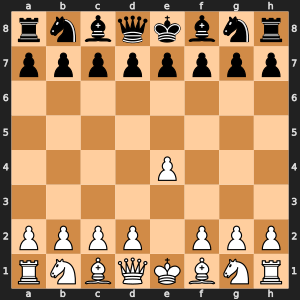


Position 2: Evaluation = +56


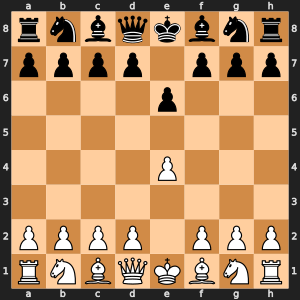


Position 3: Evaluation = -9


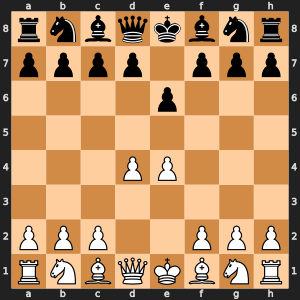

In [1]:
import pandas as pd
import chess
import chess.svg
from IPython.display import display, SVG

# Load the CSV
DATA_PATH = "data/chessData.csv"

df = pd.read_csv(DATA_PATH).head(3)

# Display each board with its evaluation
for idx, row in df.iterrows():
    fen = row['FEN']
    evaluation = row['Evaluation']
    
    board = chess.Board(fen)
    print(f"\nPosition {idx + 1}: Evaluation = {evaluation}")
    display(SVG(chess.svg.board(board=board, size=300)))


In [2]:
df

,FEN,Evaluation
0,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,-10
1,rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBN...,+56
2,rnbqkbnr/pppp1ppp/4p3/8/3PP3/8/PPP2PPP/RNBQKBN...,-9


# Create a function to represent chess positions efficiently
* A FEN representation gives us an (8 x 8 x 4) array where each piece (or lack thereof) is represented by a 4 bit code.
* This allows us to use a Convolutional Neural Network to evaluate positions down the line.
* We need a PyTorch dataset object to train our model quickly.

In [3]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np

# Static 4-bit encoding for each piece
BIT_ENCODING = {
    'P': [0, 0, 0, 1],
    'N': [0, 0, 1, 0],
    'B': [0, 0, 1, 1],
    'R': [0, 1, 0, 0],
    'Q': [0, 1, 0, 1],
    'K': [0, 1, 1, 0],
    'p': [1, 0, 0, 1],
    'n': [1, 0, 1, 0],
    'b': [1, 0, 1, 1],
    'r': [1, 1, 0, 0],
    'q': [1, 1, 0, 1],
    'k': [1, 1, 1, 0],
}

LEVEL_ENCODING = {
    'P': 0,
    'N': 1,
    'B': 2,
    'R': 3,
    'Q': 4,
    'K': 5,
    'p': 6,
    'n': 7,
    'b': 8,
    'r': 9,
    'q': 10,
    'k': 11,
}

EMPTY_ENCODING = [0, 0, 0, 0]

REPRES_SHAPE = (12, 8, 8)  # Channels first for PyTorch

class FastFenDataset(Dataset):
    def __init__(self, csv_path: str, limit: int = None):
        """
        Args:
            csv_path (str): Path to CSV file with 'fen' and optional 'eval' column.
            limit (int): Optional limit on number of rows (for debugging).
        """
        self.data = pd.read_csv(csv_path)
        if limit:
            self.data = self.data.head(limit)
        self.has_eval = 'Evaluation' in self.data.columns

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        fen = self.data.iloc[idx]['FEN']
        board_tensor = self.fen_to_tensor(fen)
        if self.has_eval:
            score = torch.tensor(
                float(self.data.iloc[idx]['Evaluation'].replace('+', '').replace('#', '')) / 100, 
                dtype=torch.float32
            )
            return board_tensor, score
        else:
            return board_tensor

    @staticmethod
    def fen_to_tensor(fen: str) -> torch.Tensor:
        """
        Converts the piece placement part of a FEN string to a (4, 8, 8) tensor.
        Uses python-chess for clarity.
        """
        piece_part = fen.split()[0]
        tensor = np.zeros((12, 8, 8), dtype=np.uint8)
        row, col = 0, 0

        for char in piece_part:
            if char == '/':
                row += 1
                col = 0
            elif char.isdigit():
                col += int(char)
            else:
                encoding = LEVEL_ENCODING.get(char)
                if encoding is not None:
                    tensor[encoding, row, col] = 1
                col += 1

        return torch.from_numpy(tensor).float()

    '''
    @staticmethod
    def fen_to_tensor(fen: str) -> torch.Tensor:
        """
        Converts the piece placement part of a FEN string to a (4, 8, 8) tensor.
        Fast version without using python-chess.
        """
        piece_part = fen.split()[0]
        board = np.zeros((8, 8, 4), dtype=np.uint8)
        row, col = 0, 0

        for char in piece_part:
            if char == '/':
                row += 1
                col = 0
            elif char.isdigit():
                col += int(char)
            else:
                encoding = BIT_ENCODING.get(char, EMPTY_ENCODING)
                board[row, col] = encoding
                col += 1

        # Transpose to (4, 8, 8) for PyTorch conv input
        return torch.from_numpy(board).permute(2, 0, 1).float()
    '''


# Create a Lightning Module to speed things up

In [11]:
import torch
from torch.utils.data import DataLoader, random_split
from pytorch_lightning import LightningDataModule

from pathlib import Path

class FenDataModule(LightningDataModule):
    def __init__(self, csv_path, batch_size=64, num_workers=0, val_split=0.1, test_split=0.1, max_samples=None, seed=42):
        super().__init__()
        self.csv_path = csv_path
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.val_split = val_split
        self.test_split = test_split
        self.seed = seed
        self.max_samples = max_samples

    def setup(self, stage=None):
        
        # Assert data file exists
        assert Path(self.csv_path).exists(), f"File not found: {self.csv_path}"
        
        # Load full dataset
        full_dataset = FastFenDataset(self.csv_path, self.max_samples)
        
        # Dataset sizes
        total_size = len(full_dataset)
        test_size = int(self.test_split * total_size)
        val_size = int(self.val_split * total_size)
        train_size = total_size - val_size - test_size

        # Split dataset (reproducibly)
        self.train_set, self.val_set, self.test_set = random_split(
            full_dataset, [train_size, val_size, test_size],
            generator=torch.Generator().manual_seed(self.seed)
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_set, batch_size=self.batch_size, shuffle=True,
            num_workers=self.num_workers, pin_memory=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_set, batch_size=self.batch_size, shuffle=False,
            num_workers=self.num_workers, pin_memory=True
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_set, batch_size=self.batch_size, shuffle=False,
            num_workers=self.num_workers, pin_memory=True
        )

# Create a model to evaluate a position

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class ChessEvalNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Input channels = 4 (bit planes)
        # Use small conv kernels and pooling to capture local spatial patterns
        
        self.conv1 = nn.Conv2d(REPRES_SHAPE[0], 32, kernel_size=3, padding=1)  # 8x8 -> 8x8
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # 8x8 -> 8x8
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # 8x8 -> 8x8
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # 8x8 -> 8x8
        self.bn4 = nn.BatchNorm2d(256)
        
        self.pool = nn.MaxPool2d(2)  # reduce spatial dims 8x8 -> 4x4
        
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 1)  # output single scalar evaluation

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))  # (B, 32, 8, 8)
        
        # Path 1
        x = F.relu(self.bn2(self.conv2(x)))  # (B, 32, 8, 8)
        x = F.relu(self.bn3(self.conv3(x)))  # (B, 32, 8, 8)
        x = F.relu(self.bn4(self.conv4(x)))  # (B, 32, 8, 8)

        # Combine paths and Pool
        x = self.pool(x)  # (B, 32, 8, 8)

        # Fully connected layers       
        x = x.view(x.size(0), -1)  # flatten (B, 128*4*4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # (B, 1)
        return x.squeeze(1)  # (B,)


# Train the Model

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm  # progress bar

def train_model(model, train_loader, val_loader, epochs=10, device='cpu'):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    train_losses = []
    val_losses = []

    plt.ion()  # interactive mode on
    fig, ax = plt.subplots()
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title("Training and Validation Loss")
    line1, = ax.plot([], [], label="Train Loss")
    line2, = ax.plot([], [], label="Val Loss")
    ax.legend()

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        for boards, scores in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
            boards, scores = boards.to(device), scores.to(device)

            optimizer.zero_grad()
            outputs = model(boards)
            loss = criterion(outputs, scores)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * boards.size(0)

            # Save model periodically
            torch.save(model, MODEL_FILE_LOC)

        train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for boards, scores in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]"):
                boards, scores = boards.to(device), scores.to(device)
                outputs = model(boards)
                loss = criterion(outputs, scores)
                running_val_loss += loss.item() * boards.size(0)

        val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)

        # Update plot
        line1.set_data(range(1, epoch+2), train_losses)
        line2.set_data(range(1, epoch+2), val_losses)
        ax.relim()
        ax.autoscale_view()
        plt.draw()
        plt.pause(0.01)

        print()
        print(f"Epoch {epoch+1}/{epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

    plt.ioff()
    plt.show()

# Model Training Variables

In [14]:
BATCH_SIZE = 2**12
MAX_SAMPLES = 1000000
NUM_WORKERS = 0
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_FILE_LOC = "models/chess_eval_net_detailed_filters.pth"
USE_OLD_MODEL = False
NUM_EPOCHS = 20
VAL_SPLIT = 0.1
TEST_SPLIT = 0.1

# Instantiate the Model

In [15]:
if USE_OLD_MODEL and Path(MODEL_FILE_LOC).exists():
    model = torch.load(MODEL_FILE_LOC, weights_only=False).to(DEVICE)
    print("Loaded existing model from ", MODEL_FILE_LOC)
else:
    model = ChessEvalNet().to(DEVICE)

print(model)
print("\nModel instantiated on device: ", DEVICE)

ChessEvalNet(
  (conv1): Conv2d(12, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
)

Model instantiated on device:  cuda


# Instantiate the Data Loaders

In [16]:
data_module = FenDataModule(
    DATA_PATH, 
    batch_size=BATCH_SIZE, 
    num_workers=NUM_WORKERS, 
    val_split=VAL_SPLIT, 
    test_split=TEST_SPLIT,
    max_samples=MAX_SAMPLES,
)

# Prepare the data
data_module.setup()

# Get the data loaders
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()


Epoch 1/20 [Train]:  33%|███▎      | 64/196 [03:41<07:37,  3.47s/it]


KeyboardInterrupt: 

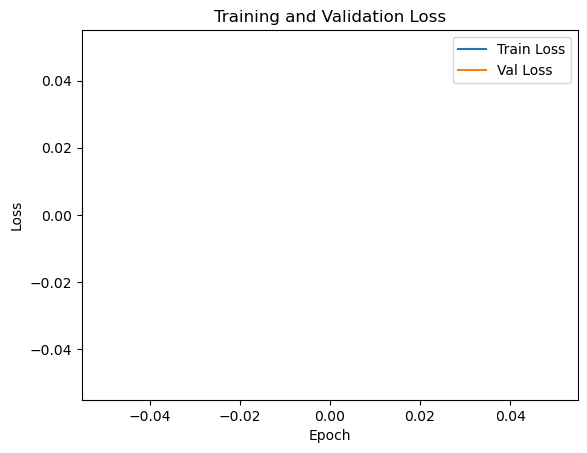

In [17]:
train_model(
    model, 
    train_loader, 
    val_loader, 
    epochs=NUM_EPOCHS, 
    device=DEVICE
)

# Create a function to play chess

In [11]:
def fen_to_tensor(fen: str) -> torch.Tensor:
    """
    Converts the piece placement part of a FEN string to a (4, 8, 8) tensor.
    Fast version without using python-chess.
    """
    piece_part = fen.split()[0]
    board = np.zeros((8, 8, 4), dtype=np.uint8)
    row, col = 0, 0

    for char in piece_part:
        if char == '/':
            row += 1
            col = 0
        elif char.isdigit():
            col += int(char)
        else:
            encoding = BIT_ENCODING.get(char, EMPTY_ENCODING)
            board[row, col] = encoding
            col += 1

    # Transpose to (4, 8, 8) for PyTorch conv input
    return torch.from_numpy(board).permute(2, 0, 1).float()

def evaluate_position(fen, model, device='cpu'):
    model.eval()
    tensor = FastFenDataset.fen_to_tensor(fen).unsqueeze(0).to(device)  # shape (1, 4, 8, 8)
    with torch.no_grad():
        eval = model(tensor).item()
    return eval

def minimax(board, model, depth, maximizing_player, device='cpu'):
    if depth == 0 or board.is_game_over():
        fen = board.fen()
        return evaluate_position(fen, model, device)

    legal_moves = list(board.legal_moves)

    if maximizing_player:
        max_eval = float('-inf')
        for move in legal_moves:
            board.push(move)
            eval = minimax(board, model, depth - 1, False, device)
            board.pop()
            max_eval = max(max_eval, eval)
        return max_eval
    else:
        min_eval = float('inf')
        for move in legal_moves:
            board.push(move)
            eval = minimax(board, model, depth - 1, True, device)
            board.pop()
            min_eval = min(min_eval, eval)
        return min_eval

def find_best_move(fen, model, depth=2, device='cpu'):
    board = chess.Board(fen)
    best_move = None
    best_eval = float('-inf')

    for move in board.legal_moves:
        board.push(move)
        eval = minimax(board, model, depth - 1, False, device)
        board.pop()
        if eval > best_eval:
            best_eval = eval
            best_move = move

    return best_move, best_eval

Current Position:


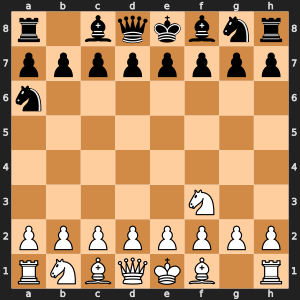

Best move: h2h3, Eval: 0.24


In [12]:
fen = "r1bqkbnr/pppppppp/n7/8/8/5N2/PPPPPPPP/RNBQKB1R w KQkq - 2 2"

board = chess.Board(fen)
print("Current Position:")
display(SVG(chess.svg.board(board=board, size=300)))

best_move, score = find_best_move(fen, model, depth=2, device='cuda')
print(f"Best move: {best_move}, Eval: {score:.2f}")

# Play against the computer

In [15]:
def play_against_model(model, depth=2, device='cpu', player_color='white', self_play=False):
    board = chess.Board()
    print("Welcome to Chess vs AI!")
    print("Enter your moves in UCI format (e.g., e2e4)")
    print("You are playing as", player_color)

    is_human_turn = (player_color == 'white')

    while not board.is_game_over():
        print("\nCurrent position:")
        display(SVG(chess.svg.board(board=board, size=300)))

        if is_human_turn and not self_play:
            print("\nYour move:")
            move_uci = input("> ").strip()

            if move_uci.lower() == 'exit':
                print("Exiting the game.")
                break

            try:
                move = chess.Move.from_uci(move_uci)
                if move in board.legal_moves:
                    board.push(move)
                    is_human_turn = False
                else:
                    print("Illegal move. Try again.")
            except:
                print("Invalid move format. Use UCI like e2e4.")
        else:
            print("\nAI is thinking...")
            move, eval = find_best_move(board.fen(), model, depth, device)
            print(f"AI plays: {move} (Eval: {eval:.2f})")
            board.push(move)
            is_human_turn = True

    print("\nGame Over!")
    print(board.result())
    print(board.outcome())


Welcome to Chess vs AI!
Enter your moves in UCI format (e.g., e2e4)
You are playing as white

Current position:


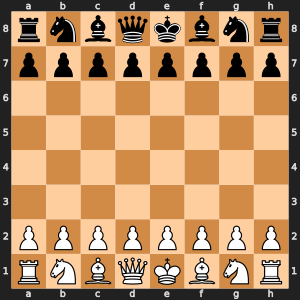


Your move:

Current position:


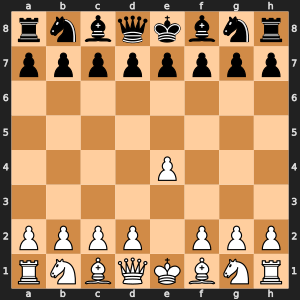


AI is thinking...
AI plays: g7g5 (Eval: 0.38)

Current position:


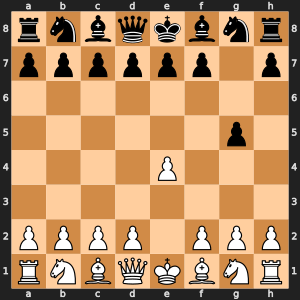


Your move:
Exiting the game.

Game Over!
*
None


In [17]:
play_against_model(model, depth=3, device=DEVICE, player_color='white', self_play=False)